In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components

In [244]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [245]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"
processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
raw.set_montage('biosemi64')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=200, verbose=False)
#I should maybe downsample, and maybe do it first for computational efficiency. The only thing is that then almost all the data will be in simpochs, so maybe I need stricter limits for gfp peakes.
#Bad segments can maybe be identified with Christoffers algorithm, anything else? I want to do this at the end of the pipeline I think.

[PCA] Explained variance of selected components : 63.02%
Power of components removed by DSS: 0.18
(245760, 64)
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.


In [246]:
print(raw_down_sampled.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2021-08-24 10:56:14 UTC
 nchan: 64
 projs: []
 sfreq: 200.0 Hz
 subject_info: 1 item (dict)
>


In [247]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

In [248]:
print(raw_down_sampled.get_data().shape)

(64, 48000)


In [249]:
data, indices, gfp, info_mne  = microstates_clean(raw_down_sampled, standardize_eeg=False)
print(indices.shape, gfp.shape, data.shape)
print(indices)
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
#new_indices = np.argpartition(gfp_peakes, -1000)[-1000:]
#new_indices = np.sort(new_indices)
#print(new_indices)
#print(new_indices.shape)
gfp_data = data[:, indices]#[:, new_indices]
print(gfp_data)
#print(neuro_gfp_data.shape)

(7686,) (48000,) (64, 48000)
[    6    11    21 ... 47982 47987 47995]
(7686,)
[[ 1.54291988e-05  9.84871741e-06 -2.23189831e-06 ...  8.73661910e-06
   8.24146808e-07  7.18538453e-06]
 [ 1.00403270e-05  9.23192515e-06 -9.43564837e-06 ...  1.25485789e-05
   6.11790670e-06  9.89576753e-06]
 [ 8.11308093e-06  2.79823231e-06 -2.15905576e-06 ...  4.99559961e-06
   8.45209447e-07  5.36041428e-06]
 ...
 [ 3.28317739e-05  3.29064336e-05  1.34717694e-05 ...  4.50167733e-07
   1.80802660e-06 -2.04602526e-06]
 [ 4.02145578e-06 -1.63576881e-06  9.71729410e-06 ...  2.84615683e-06
  -7.23090303e-07 -4.16212808e-06]
 [ 1.25368624e-05  1.47307833e-05  3.91314070e-06 ...  6.15618912e-06
   5.99539055e-06  8.20957981e-07]]


In [250]:
print(data.shape)

(64, 48000)


In [251]:
print(np.where(gfp_peakes>0.4)[0])
indices = np.delete(indices, np.where(gfp_peakes>0.4)[0])
gfp_peakes = np.delete(gfp_peakes, np.where(gfp_peakes>0.4)[0])

[3220 3221 3222 3223 3224 3225 3226 3227 3228 3231 3232 3233 3234 3235
 3236 3237 3238 3239 3240 3241]


In [252]:
print(indices.shape)

(7666,)


In [253]:
print(np.average(gfp))
print(np.std(gfp))

0.08804267014082058
0.05562630000808587


In [254]:
indices = np.delete(indices, np.where(gfp_peakes<np.average(gfp))[0])

In [255]:
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
gfp_data = data[:, indices]
print(gfp_data.shape)

(3533,)
(64, 3533)


0.046963171467901785


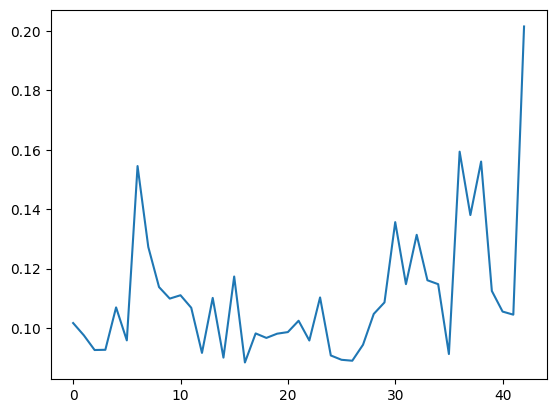

In [256]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes[3210:3253])
plt.show()
#Something wierd here for sure...

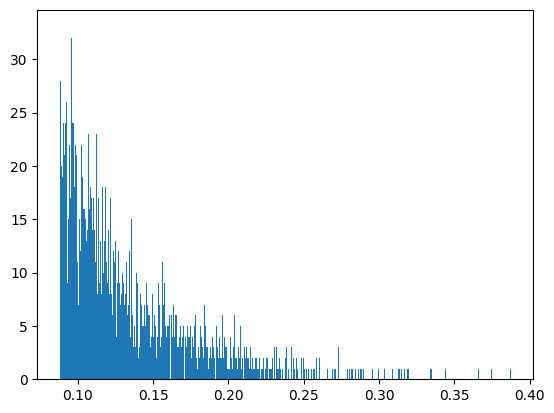

In [257]:
plt.hist(gfp_peakes, bins=1000)
plt.show()

0.046963171467901785


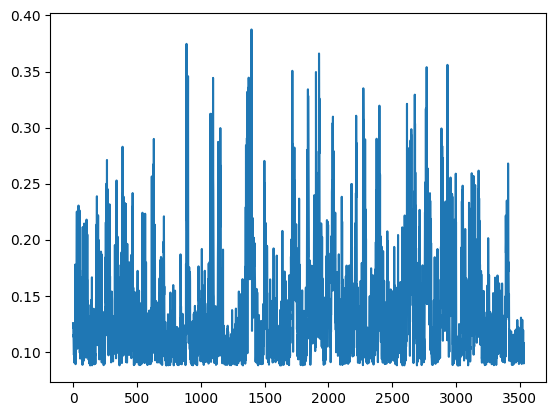

In [258]:
print(np.std(gfp_peakes))
plt.plot(gfp_peakes)
plt.show()
#Something wierd here for sure...

In [259]:
"""gfp_peakes = extract_gfp_peaks(raw_down_sampled, min_peak_distance=1)
print(gfp_peakes.get_data().shape)
top_indices = np.argpartition(np.std(gfp_peakes.get_data(), axis=0), -6003)[-6003:]
print(top_indices.shape)
gfp_data = gfp_peakes.get_data()[:, top_indices]
print(gfp_data.shape)"""

'gfp_peakes = extract_gfp_peaks(raw_down_sampled, min_peak_distance=1)\nprint(gfp_peakes.get_data().shape)\ntop_indices = np.argpartition(np.std(gfp_peakes.get_data(), axis=0), -6003)[-6003:]\nprint(top_indices.shape)\ngfp_data = gfp_peakes.get_data()[:, top_indices]\nprint(gfp_data.shape)'

In [260]:
all_inx = np.arange(raw_down_sampled.get_data().shape[1])
drop = np.delete(all_inx, indices)
sim_indices = np.array([indices, (indices-1)]).flatten()
all_inx = np.arange(raw_down_sampled.get_data().shape[1])
simpochs_indices = np.delete(all_inx, sim_indices)


In [261]:
print(len(all_inx))
print(indices.shape)
print(sim_indices.shape)

48000
(3533,)
(7066,)


In [262]:
print(drop.shape)
print(simpochs_indices.shape) #Something wierd here...

(44467,)
(40934,)


In [263]:
print(indices)
print(sim_indices)

[    6    11    26 ... 47465 47542 47945]
[    6    11    26 ... 47464 47541 47944]


In [264]:
epochs = mne.make_fixed_length_epochs(raw_down_sampled, duration = 1/raw_down_sampled.info['sfreq'], verbose=False, preload=True)

In [265]:
print(epochs.info)

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2021-08-24 10:56:14 UTC
 nchan: 64
 projs: []
 sfreq: 200.0 Hz
 subject_info: 1 item (dict)
>


In [266]:
epochs.drop(drop)

Dropped 44467 epochs: 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 142, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 23

Number of events,3533
Events,1: 3533
Time range,0.000 – 0.000 s
Baseline,off


In [267]:
simpochs = mne.make_fixed_length_epochs(raw_down_sampled, duration = 1/raw_down_sampled.info['sfreq'], verbose=False, preload=True)

In [268]:
simpochs.drop(simpochs_indices)

Dropped 40934 epochs: 0, 1, 2, 3, 4, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 110, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 138, 139, 144, 145, 146, 147, 148, 149, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 175, 176, 177, 178, 179, 180, 181, 184, 185, 186, 187, 190, 191, 192, 193, 194, 195, 196, 197, 198, 201, 202, 203, 204, 205, 206, 207, 208, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 247, 248, 249, 250, 251, 252, 253, 256, 257, 258, 259, 260, 261, 262, 2

Number of events,7066
Events,1: 7066
Time range,0.000 – 0.000 s
Baseline,off


In [269]:
ica = mne.preprocessing.ICA(max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
    n_components=10
    )

In [270]:
ica.fit(epochs)
#Do I feed enough data to ICA?

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 10 components
Computing Extended Infomax ICA
Fitting ICA took 1.9s.


Method,infomax
Fit,500 iterations on epochs (3533 samples)
ICA components,10
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=10, n_times=48000
    Range : 0 ... 47999 =      0.000 ...   239.995 secs
Ready.


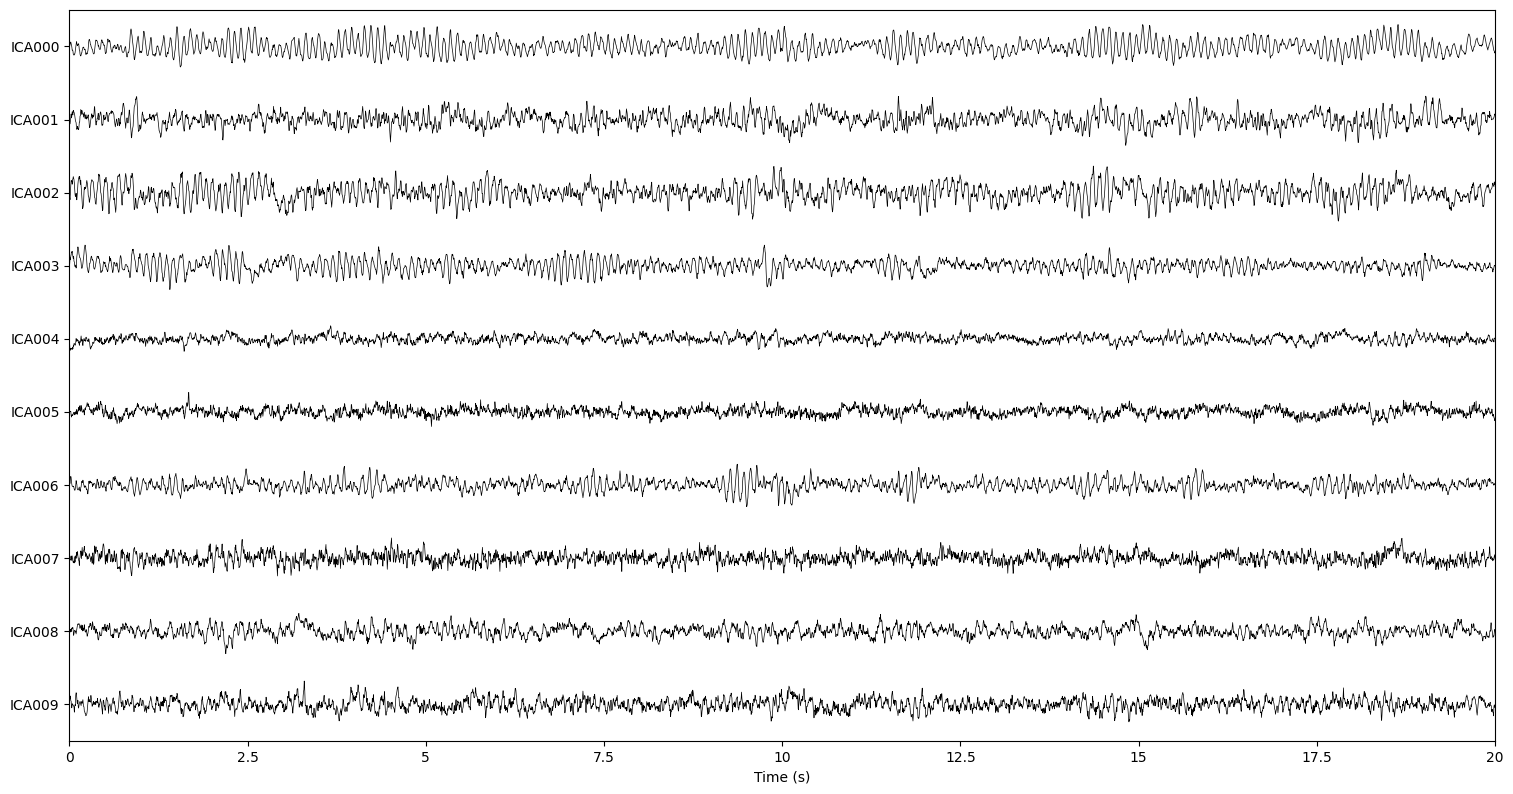

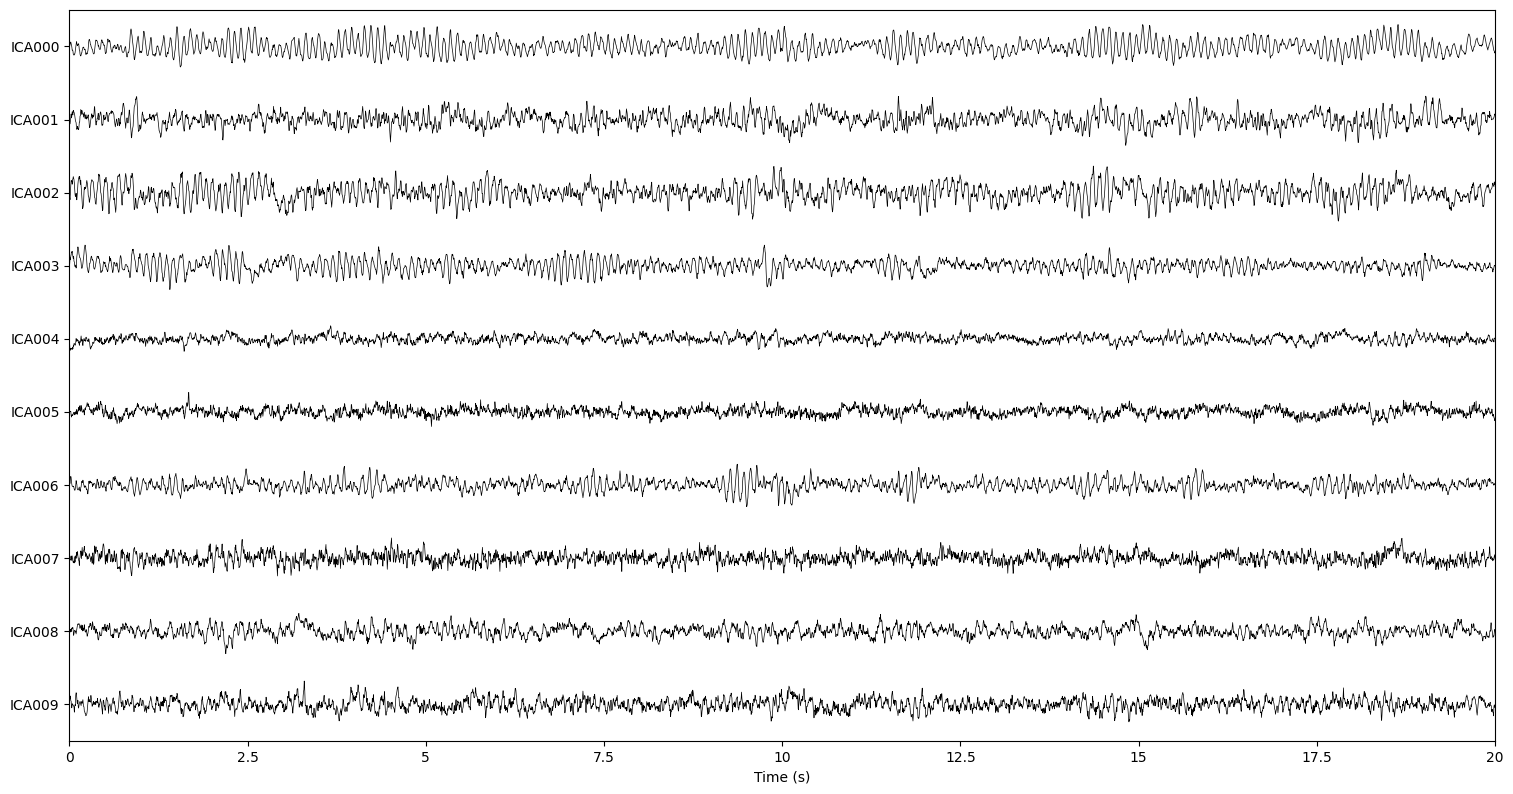

In [271]:
ica.plot_sources(raw_down_sampled, show_scrollbars=False, show=True)

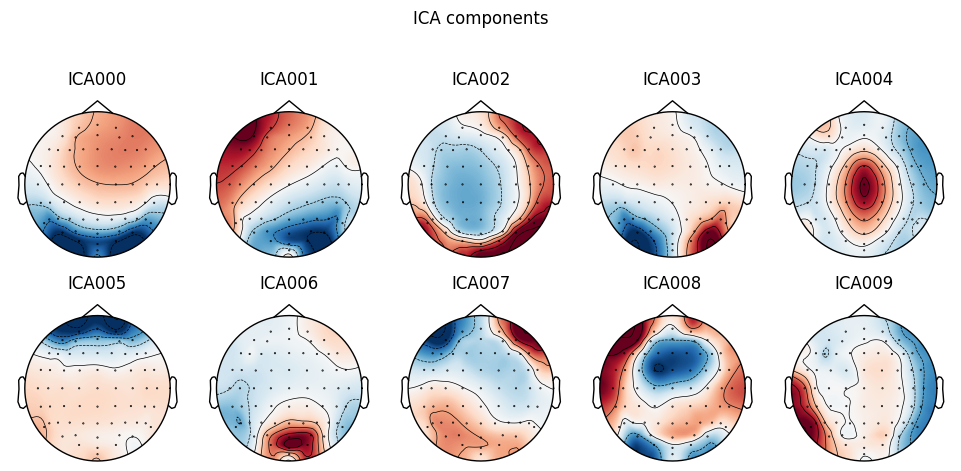

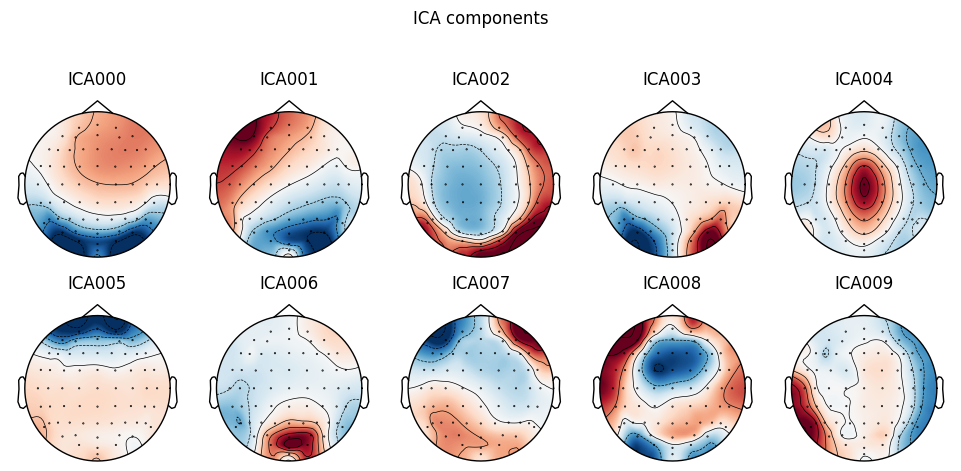

In [272]:
ica.plot_components()
#Something wierd with component 1 here for sure, hence the wish for bad segment excluder. 

In [273]:
ic_labels = label_components(raw_down_sampled, ica, method='iclabel')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [274]:
print(ic_labels)

{'y_pred_proba': array([0.9994029 , 0.9817469 , 0.9694553 , 0.99089426, 0.6068487 ,
       0.9392128 , 0.9985342 , 0.60500157, 0.647311  , 0.9758828 ],
      dtype=float32), 'labels': ['brain', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'other', 'brain']}


In [275]:
s = ica.get_sources(epochs)

In [276]:
s.get_data().shape

(3533, 10, 1)

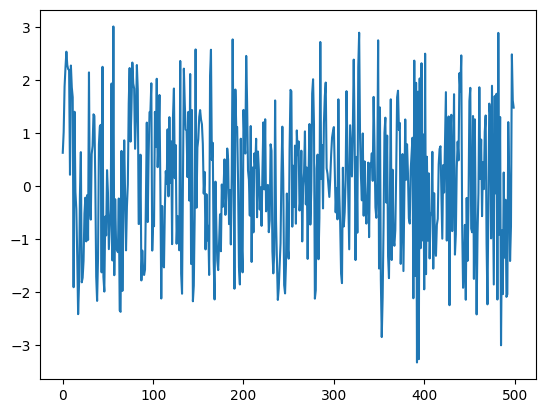

In [277]:
plt.plot(s.get_data()[500:1000, 1, 0])
plt.show()

In [278]:
print(s.get_data()[1, 0, 0], s.get_data()[1, 1, 0], s.get_data()[1, 2, 0], s.get_data()[1, 3, 0], s.get_data()[1, 4, 0], s.get_data()[1, 5, 0], s.get_data()[1, 6, 0])

-1.1537190326239017 1.3423133712885715 2.2892024459167524 0.989223349603027 -1.0351639727911635 -0.21364683064828022 -0.1414192945722132


In [279]:
print(simpochs.get_data().shape)

(7066, 64, 1)


the square root of the mean of squared differences between GFP normalized electrodes.

In [280]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, sim_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    print(indexed_data[:, -1])

    print(indexed_gfp[-1])
    gfp_normed = indexed_data/indexed_gfp

    print(gfp_normed[:, -1])

    return gfp_normed

In [281]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    print(gfp_normed_data.shape)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return(diss)

In [282]:
print(data.shape)

(64, 48000)


In [283]:
d = diss(data, gfp, indices)
print(d.shape)

[ 3.23914361e-06  1.60860085e-05  8.23613417e-06  1.17822005e-05
  1.33006577e-05  1.60754451e-05  1.59031570e-05  1.29382531e-05
  9.01388622e-06  7.69274933e-06  1.95970296e-05  6.36120135e-06
  6.73126150e-06  1.02711530e-05  1.36238578e-05  1.21783233e-05
  5.60051318e-06  6.92618759e-06  8.13385466e-07 -2.64587168e-07
  3.24744002e-06  6.91976008e-06  7.42385261e-06  8.22462476e-06
  6.66653160e-06  3.71578877e-06  2.35677590e-06 -4.08350997e-08
 -5.50513009e-06 -3.74175248e-06 -3.08902331e-06 -3.77152264e-06
 -1.21114087e-06 -8.63383765e-06 -1.51811795e-05 -5.44441934e-06
 -7.13625761e-07  1.25553105e-06 -3.10250138e-06 -1.19050495e-05
 -1.20297952e-05 -1.44211190e-05 -1.40768085e-05 -1.08738339e-05
 -1.04718446e-05 -8.49492445e-06 -1.15601296e-06 -3.53091165e-06
 -8.56486331e-06 -8.86041454e-06 -9.96515070e-06 -8.12169623e-06
 -4.45231554e-06 -6.81125658e-06 -7.50480713e-06 -6.15524866e-06
 -3.11730419e-06 -5.85509489e-06 -8.36517227e-06 -6.13691818e-06
 -3.49229698e-06 -5.30918

In [284]:
stability = np.mean(d, axis=0)
print(stability.shape)

(64,)


In [285]:
print(stability)

[1.58134115e-09 9.96790285e-10 6.70730498e-10 2.86209765e-10
 3.17494988e-10 8.32152687e-10 5.13989203e-10 6.52742473e-10
 5.47792709e-10 3.48238024e-10 5.22386299e-10 3.10050598e-10
 3.11151020e-10 5.89592110e-10 1.46541142e-09 5.41904930e-10
 4.71929223e-10 3.96213454e-10 2.59270169e-10 3.03177783e-10
 2.84279100e-10 3.58565973e-10 6.29819689e-10 8.86285339e-10
 9.05016095e-10 4.05719963e-10 7.38544670e-10 8.96390944e-10
 5.36694832e-10 4.89723826e-10 2.82795778e-10 2.84047086e-10
 7.04587846e-10 2.82593001e-09 1.47320820e-09 4.80648677e-10
 2.76535714e-10 1.95162249e-10 2.11711186e-10 3.02641950e-10
 6.69729034e-10 1.13724228e-09 1.53925334e-09 1.78650078e-09
 3.36690006e-10 2.34689844e-10 2.64893174e-10 2.64610139e-10
 2.03217287e-10 4.69704012e-10 1.45208588e-09 1.00949930e-09
 6.70909703e-10 5.44392450e-10 2.87454254e-10 2.45142109e-10
 2.38379291e-10 3.38040859e-10 3.97415377e-10 7.10671004e-10
 9.17475388e-10 1.21138015e-09 4.78413184e-10 8.32105960e-10]


In [286]:
order = np.argsort(stability)
print(channel_names[order])

['Fz' 'C2' 'F2' 'FC2' 'P2' 'CP2' 'CP1' 'Cz' 'FCz' 'AFz' 'Pz' 'CPz' 'P3'
 'F1' 'CP4' 'F4' 'P1' 'C1' 'C3' 'F3' 'FC4' 'P4' 'FC3' 'P5' 'CP3' 'P6'
 'PO3' 'C4' 'CP5' 'PO4' 'AF4' 'POz' 'F7' 'FC1' 'Oz' 'TP7' 'CP6' 'FC5' 'C5'
 'P7' 'FT7' 'F6' 'AF3' 'TP8' 'Fpz' 'P8' 'O1' 'O2' 'F5' 'P9' 'Iz' 'PO7'
 'P10' 'AF7' 'T8' 'F8' 'PO8' 'C6' 'T7' 'AF8' 'FT8' 'Fp1' 'FC6' 'Fp2']


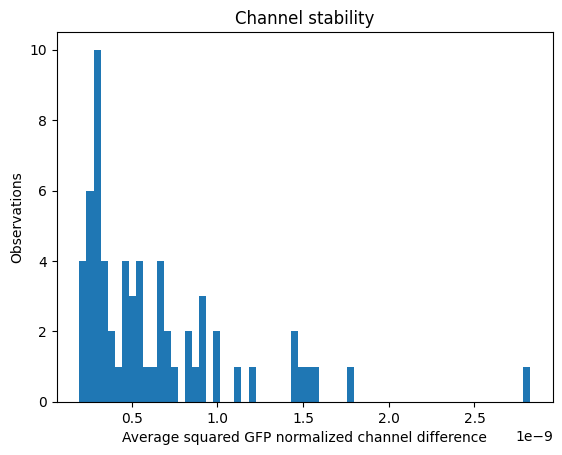

In [287]:
plt.hist(stability, bins=64)
plt.xlabel('Average squared GFP normalized channel difference')
plt.ylabel('Observations')
plt.title('Channel stability')
plt.show()

4.766486450544236e-10


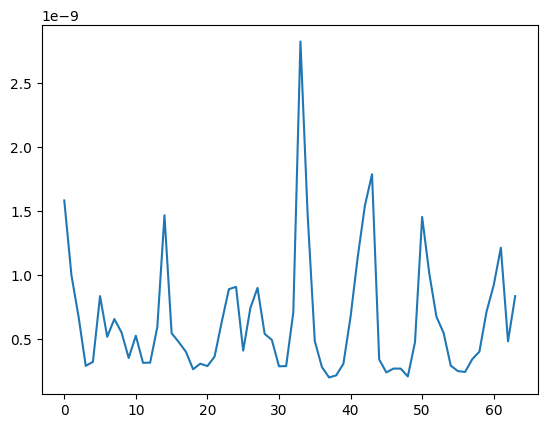

In [288]:
print(np.std(stability))
plt.plot(stability)
plt.show()

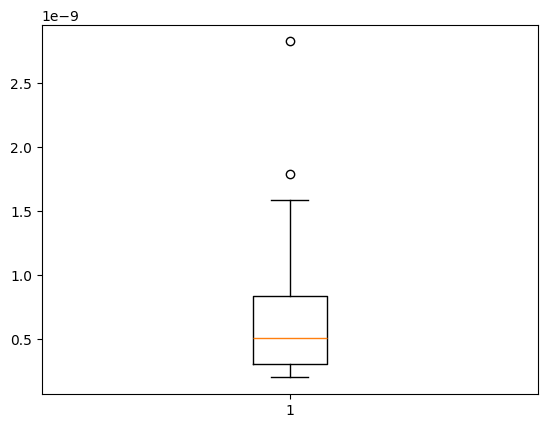

In [289]:
plt.boxplot(stability)
plt.show()